In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
def load_data(train, test, fname) :
    fpath = "trained_models/resnet18_{}_piecewise_eps8_bs256_maxlr0.1_BNeval/eval/{}/{}.txt".format(train, test, fname)
    return np.loadtxt(fpath).astype(np.int)

train = "autoattack"
test = "pgd"

y_robust = load_data(train, test, "y_robust")
y_robust_pred = load_data(train, test, "y_robust_pred")
y_cross_robust = load_data(train, test, "y_cross_robust")
y_cross_robust_pred = load_data(train, test, "y_cross_robust_pred")

Let :

$Y = \{y_1, y_2, y_3, ... , y_n \}$ -> the original label

$P^{M_C}_{X_B} = \{p_1, p_2, p_3, ... , p_n \}$ -> the prediction of model $M_C$ on $X_B$

$E^{M}_{X_B} = \{id, \quad id \in Y \land id \in P^{M}_{X_B} \land y_{id} \neq p_{id} \}$ -> a list of failed test cases where prediction of the model ${M}$ is incorrect on $X_B$

$E^{M_C}_{X_B} = \{id, \quad id \in Y \land id \in P^{M_C}_{X_B} \land y_{id} \neq p_{id} \}$ -> a list of failed test cases where prediction of the robust ${M_C}$ is wrong for $X_B$

$Difference(List_1, List_2) = \{ id, \quad id \in List_1 \land id \not \in List_2 \}$

$R^C_B = Difference(E^{M}_{X_B}, E^{M_C}_{X_B})$

$R^B_B = Difference(E^{M}_{X_B}, E^{M_B}_{X_B})$

$Intersection(List_2, List_2) = \{ id, \quad id \in List_1 \land id \in List_2 \} $

Inspired from Jaccard simmilarity, we propose BSEM to measure the similarity of bug-attaccking behavior from adversarial attack

$BSEM_{C-fix-B} = \frac{Length(Intersection(R^C_B, R^B_B))}{Length(R^C_B) + Length(R^B_B) - Length(Intersection(R^C_B, R^B_B))}$

$BSEM_{B-fix-C} = \frac{Length(Intersection(R^B_C, R^C_C))}{Length(R^B_C) + Length(R^C_C) - Length(Intersection(R^B_C, R^C_C))}$

$BSEM(B,C) = \frac{BSEM_{B-fix-C} + BSEM_{C-fix-B}}{2}$

Note: simplify rumus

Jaccard

Failed Test Cases instead of Robust


In [38]:
def get_robust_data(train, test):
    y_adv = load_data(train, test, "y_cross_robust")
    y_adv_pred = load_data(train, test, "y_cross_robust_pred")
    return y_adv, y_adv_pred

train = "pgd"
test = "autoattack"
y_adv, y_adv_pred = get_robust_data(train, test)

print("Y_adv({},{}): {}".format(train, test, y_adv))
print("Y_adv_pred({},{}): {}".format(train, test, y_adv_pred))

Y_adv(pgd,autoattack): [3 8 8 ... 5 1 7]
Y_adv_pred(pgd,autoattack): [3 8 0 ... 5 1 7]


In [80]:
def error(l1, l2):
    if len(l1) != len(l2) :
        raise ValueError("The array length must be same")
#     err = []
#     for i in range(len(l1)) :
#         if l1[i] != l2[i] :
#             err.append(i)
#     return np.array(err)
    check = np.not_equal(l1, l2)
    return np.argwhere(check == True).reshape(-1)


def repair(l1, l2) :
#     return [x for x in l1 if x not in l2]
    return l1[np.isin(l1, l2, invert=True)]

y1, y1_pred = get_robust_data("original", test)
y2, y2_pred = get_robust_data(train, test)

# print(error([0,1,2], [0,5,2]))

R = repair(error(y1, y1_pred), error(y2, y2_pred))
len(R)

7289

In [81]:
def match(l1, l2) :
#     return [x for x in l1 if x in l2]
    return l1[np.isin(l1, l2)]

len(match(R,R))

7289

In [139]:
def get_repair(train, test): 
    y1, y1_pred = get_robust_data("original", test)
    y2, y2_pred = get_robust_data(train, test)
    R = repair(error(y1, y1_pred), error(y2, y2_pred))
    return R

def one_pov_relation(train, test) :
    R_train_test = get_repair(train, test)
    R_test_test = get_repair(test, test)
    
    intersection = len(match(R_train_test, R_test_test))
    union = len(R_train_test) + len(R_test_test) - intersection
    
    return intersection / union

one_pov_relation(train, test)

0.7565426170468187

In [140]:
def BSEM(a1, a2) :
    return (one_pov_relation(a1, a2) + one_pov_relation(a2, a1))/2

BSEM(train, test)

0.7538137386101982

In [141]:
BSEM("pixelattack", "autoattack")

0.09236401499721504

In [142]:
BSEM("squareattack", "autoattack")

0.6442275274749332

In [143]:
BSEM("pgd", "fgsm")

0.6829271124477849

In [144]:
BSEM("cw", "fgsm")

0.6825935513920007

In [145]:
from constant import TOOLBOX_ADV_ATTACK_LIST

# TOOLBOX_ADV_ATTACK_LIST = ["autoattack", "deepfool", "fgm", "pgd", "squareattack"]

TOOLBOX_ADV_ATTACK_LIST = ["autoattack", "autopgd", "bim", "cw", "fgsm", "pgd", "deepfool", "newtonfool", "squareattack", "pixelattack", "spatialtransformation"]
# TOOLBOX_ADV_ATTACK_LIST = ["autoattack", "autopgd", "bim", "cw", "deepfool", "fgsm", "jsma", "newtonfool", "pixelattack", "pgd",  "squareattack"]

attacks = TOOLBOX_ADV_ATTACK_LIST

In [146]:
metrics = {}
for a1 in attacks :
    m = {}
    for a2 in attacks :
        m[a2] = one_pov_relation(a1, a2)
    metrics[a1] = m  
    
one_bsem = pd.DataFrame(data=metrics)

In [147]:
# def plot_heatmap(data, cmap, path, annot=False) :
#     sns.set_theme(style="white")

#     # Draw the heatmap with the mask and correct aspect ratio
#     if annot :
#         f, ax = plt.subplots(figsize=(12, 6))
#         f = sns.heatmap(data, cmap=cmap, vmax=1, center=0, annot=annot, fmt=".3f",
#                         linewidths=.5, cbar_kws={"shrink": .5})
#         f.figure.savefig(path, bbox_inches='tight')
#     else :
#         # Set up the matplotlib figure
#         f, ax = plt.subplots(figsize=(8, 5))
#         f = sns.heatmap(data, cmap=cmap, vmax=1, center=0,
#                 square=True, linewidths=.5, cbar=False)
#         f.figure.savefig(path, bbox_inches='tight')

def plot_heatmap(metrics, cmap, fpath, vmin, vmax, annot=True): 

    df = pd.DataFrame(data=metrics)

    plt.figure(figsize=(12,9))
    fig = sns.heatmap(df, cmap=cmap, vmin=vmin, vmax=vmax, annot=annot, fmt=".3f", linewidth=0.7)
#     fig.set(xlabel='Train', ylabel='Test')
    fig.figure.savefig(fpath, bbox_inches='tight')
    plt.show()

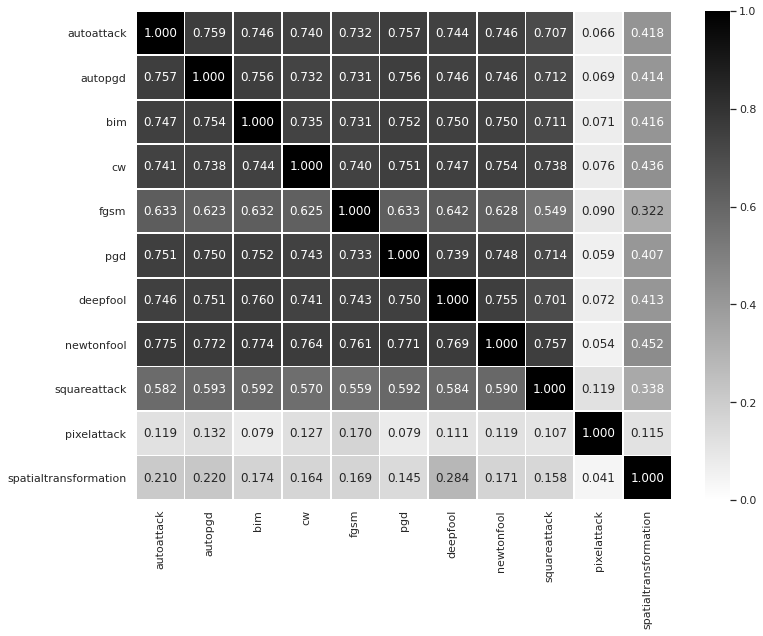

In [148]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(h_neg=240, h_pos=0,s=75, l=50, n=1, as_cmap=True)

path = "plot/rq2-one-bsem.png"

plot_heatmap(one_bsem, "binary", path, 0, 1)

In [149]:
metrics = {}
for a1 in attacks :
    m = {}
    for a2 in attacks :
        m[a2] = BSEM(a1, a2)
    metrics[a1] = m  
    
bsem = pd.DataFrame(data=metrics)

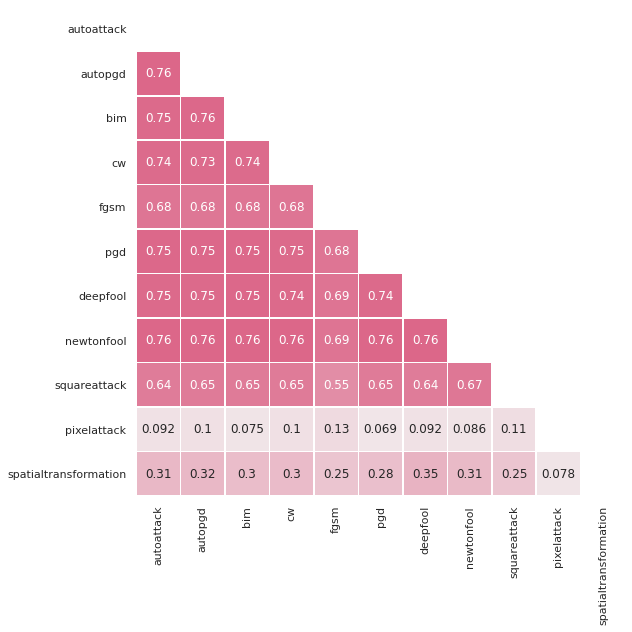

In [150]:
def plot_half_heatmap(data, cmap, path) :
    sns.set_theme(style="white")

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(data, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 9))

    # Draw the heatmap with the mask and correct aspect ratio
    f = sns.heatmap(data, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar=False, annot=True)
    f.figure.savefig(path, bbox_inches='tight')


# Generate a custom diverging colormap
cmap = sns.diverging_palette(h_neg=240, h_pos=0,s=75, l=50, n=1, as_cmap=True)

path = "plot/rq2-bsem.png"

plot_half_heatmap(bsem, cmap, path)